In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_groups = [
    ['Testis'],
    ['Ovary'],
    ['Cells_EBV-transformed_lymphocytes'],
    [
        'Brain_Caudate_basal_ganglia',
        'Brain_Cerebellar_Hemisphere',
        'Brain_Cortex',
        'Brain_Frontal_Cortex_BA9',
    ],
]

basic_tissues = [
    'Testis',
    'Ovary',
    'Cells_EBV-transformed_lymphocytes',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
]

basic_tissue_dict = {t : i for i, t in enumerate(basic_tissues)}

tissue_scalers = [
    None,
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]

tissue_scales = [
    0.,
    0.05,
    0.05,
    0.05,
    0.05,
]

correct_tissue_scalers = [
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]


In [3]:

version_suffix = '_lead_aparent'


In [4]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

spearman_rs = np.zeros((len(basic_tissues), len(tissue_scalers)))

correct_spearman_rs = []

blacklist_ids = [
    'chr5_76728085_C_T'
]

for tissue_ix, tissue_type in enumerate(basic_tissues) :
    
    for scaler_ix in range(len(tissue_scalers)) :

        snp_pred_df = pd.read_csv("predictions/apa_gtex_data/human_convnet_16_16_no_dense_linear_leslie_hek293_testis_bootstrap_predictions_pred_df.csv", sep='\t')
        snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

        snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

        snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

        if tissue_scalers[scaler_ix] is not None :
            ensemble_df = pd.read_csv("predictions/apa_gtex_data/" + tissue_scalers[scaler_ix] + "_predictions_pred_df.csv", sep='\t').query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

            snp_pred_df['ref_tissue_score_1'] = ensemble_df['ref_tissue_score_1']
            snp_pred_df['ref_tissue_score_2'] = ensemble_df['ref_tissue_score_2']
            snp_pred_df['var_tissue_score_1'] = ensemble_df['var_tissue_score_1']
            snp_pred_df['var_tissue_score_2'] = ensemble_df['var_tissue_score_2']
        else :
            snp_pred_df['ref_tissue_score_1'] = 0.
            snp_pred_df['ref_tissue_score_2'] = 0.
            snp_pred_df['var_tissue_score_1'] = 0.
            snp_pred_df['var_tissue_score_2'] = 0.

        #snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * ((snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1']) + (snp_pred_df['ref_tissue_score_2'] - snp_pred_df['ref_tissue_score_1'])) / 2.
        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * (snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1'])

        #PDUI
        snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
        snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

        snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

        lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

        lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

        lead_snp_pred_df_backup = lead_snp_pred_df

        filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

        filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

        y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
        y_true = np.ravel(np.array(filtered_df['effect_size'].values))

        spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)

        spearman_rs[tissue_ix, scaler_ix] = spearman_r_val
        
        if tissue_scalers[scaler_ix] == correct_tissue_scalers[tissue_ix] :
            correct_spearman_rs.append(spearman_r_val)


In [5]:

suffix = '_005'


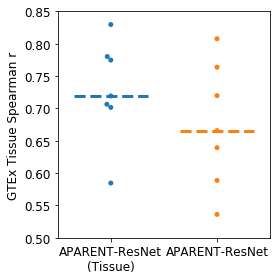

In [6]:
#Compare predictor r-values

import seaborn as sns

f = plt.figure(figsize=(4, 4))

ax = sns.swarmplot(data=[correct_spearman_rs, spearman_rs[:, 0]])

r_medians = [np.median(correct_spearman_rs), np.median(spearman_rs[:, 0])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, r_m in enumerate(r_medians) :
    plt.plot([i - 0.35, i + 0.35], [r_m, r_m], linewidth=3, linestyle="--", color=colors[i])

plt.xticks([0, 1], ['APARENT-ResNet\n(Tissue)', 'APARENT-ResNet'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0.5, .85)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.eps")

plt.show()


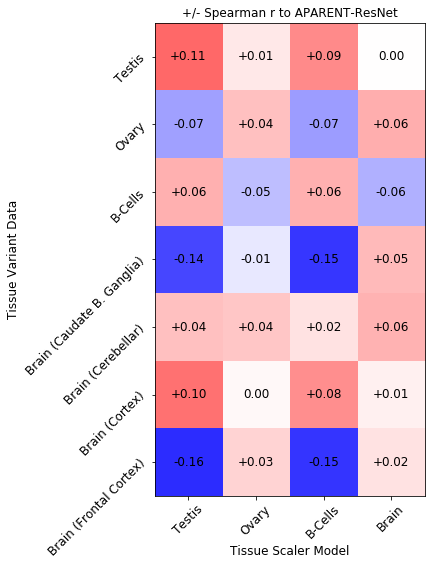

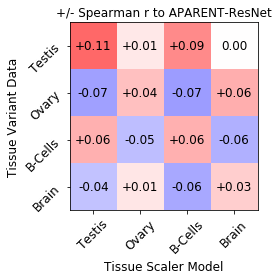

In [7]:
#Expanded Brain Tissues

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain (Caudate B. Ganglia)', 'Brain (Cerebellar)', 'Brain (Cortex)', 'Brain (Frontal Cortex)']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(8, 8))

plt.imshow(spearman_rs[:, 1:] - spearman_rs[:, 0][:, None], cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs.shape[0]) :
    for j in range(spearman_rs.shape[1] - 1) :
        
        spearm_str = str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.eps")

plt.show()

#Collapsed Brain Tissues

spearman_rs_collapsed = spearman_rs[:, 1:] - spearman_rs[:, 0][:, None]
spearman_rs_collapsed[3:, :] = np.median(spearman_rs_collapsed[3:, :], axis=0)
spearman_rs_collapsed = spearman_rs_collapsed[:4, :]

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(4, 4))

plt.imshow(spearman_rs_collapsed, cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs_collapsed.shape[0]) :
    for j in range(spearman_rs_collapsed.shape[1]) :
        
        spearm_str = str(spearman_rs_collapsed[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str(spearman_rs_collapsed[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.eps")

plt.show()
